In [2]:
## mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install category_encoders

     |████████████████████████████████| 86 kB 3.3 MB/s 


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve

import sklearn.metrics as sm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor

from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from imblearn.under_sampling import RandomUnderSampler

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Load the data

df = pd.read_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Data/df_final.csv',index_col = 0)

# drop the columns that includes only one value
# and categorical variables that has too many values
df = df.drop(columns = ['israteperstay'])

# convert to some binary features to bool
df['ispromo']  = (df['ispromo']== 'Y')

df['Source']  = (df['Source']== 5)

# Use target encoding to transform the categorical variables that have too many unique values
encoder = TargetEncoder()
df[['roomtype','city','country','ratetype','propertytype']] = encoder.fit_transform(df[['roomtype',
                                                                                        'city',
                                                                                        'country',
                                                                                        'ratetype',
                                                                                        'propertytype']], 
                                                                                    df['price'])

# convert the boolean terms into integers
df = df*1


# df.to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Data/df_final_new.csv', index=False)

# extract the feature and target from the dataset
X_dev = df.loc[:, df.columns != 'price']
y_dev = np.log(df.loc[:, df.columns == 'price'])

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_dev, 
                                                    y_dev, 
                                                    test_size=0.2,  
                                                    random_state=123)

## Baseline Regressor

In [ ]:
# Create a baseline regressor to examine advanced models
dummy_regr = DummyRegressor(strategy="median")

dummy_regr.fit(X_train, y_train)

train_mae_dummy = sm.mean_absolute_error(y_train, 
                                   dummy_regr.predict(X_train))

test_mae_dummy = sm.mean_absolute_error(y_test, 
                                  dummy_regr.predict(X_test))

print(f"The best training MAE is   : {round(train_mae_dummy,3)}")
print(f"The best testing MAE is    : {round(test_mae_dummy,3)}")

print(f"The training R Square is   : {round(dummy_regr.score(X_train, y_train),4)}")
print(f"The testing R Square is   : {round(dummy_regr.score(X_test, y_test),4)}")

The best training MAE is   : 0.433
The best testing MAE is    : 0.432
The training R Square is   : -0.0064
The testing R Square is   : -0.0058


## Decision Tree Regressor

### Default Settings

In [ ]:
# tree_para = {'max_depth':[25,50,75,100],
#              'max_features':[15,20,25,30]}

# clf_dt = GridSearchCV(DecisionTreeRegressor(random_state = 123), 
#                    tree_para, 
#                    cv=5)

# clf_dt.fit(X_train, y_train)

# train_mae_dt = sm.mean_absolute_error(y_train, 
#                                    clf_dt.best_estimator_.predict(X_train))

# test_mae_dt = sm.mean_absolute_error(y_test, 
#                                   clf_dt.best_estimator_.predict(X_test))

# print(f"The optimal parameter is   : {clf_dt.best_params_}")
# print(f"The best training MAE is   : {round(train_mae_dt,3)}")
# print(f"The best testing MAE is    : {round(test_mae_dt,3)}")

# print(f"The training accuracy is   : {round(clf_dt.score(X_train, y_train)*100,4)}%")
# print(f"The testing accuracy is    : {round(clf_dt.score(X_test, y_test)*100,4)}%")

# The optimal parameter is   : {'max_depth': 15, 'max_features': 15}

In [6]:
dt = DecisionTreeRegressor(random_state = 123, 
                           max_depth= 25, 
                           max_features= 15)

dt.fit(X_train, y_train)

train_mae_dt = sm.mean_absolute_error(y_train, 
                                      dt.predict(X_train))

test_mae_dt = sm.mean_absolute_error(y_test, 
                                     dt.predict(X_test))

print(f"The best training MAE is   : {round(train_mae_dt,3)}")
print(f"The best testing MAE is    : {round(test_mae_dt,3)}")

print(f"The training R Square is   : {round(dt.score(X_train, y_train),4)}")
print(f"The testing R Square is    : {round(dt.score(X_test, y_test),4)}")

The best training MAE is   : 0.056
The best testing MAE is    : 0.168
The training R Square is   : 0.9537
The testing R Square is    : 0.7747


In [ ]:
fig = plt.figure(figsize = (80, 20))

tree.plot_tree(dt, 
               feature_names= X_dev.columns, 
               # class_names = np.array(['0','1']), 
               filled = True, 
               fontsize=6)
plt.show()

In [9]:
dt_feature_importance = pd.DataFrame({
    'Feature Name': dt.feature_names_in_,
    'Feature Importance': dt.feature_importances_,
})

dt_feature_importance = dt_feature_importance.nlargest(10, 'Feature Importance')



### Feature Selection
Consisting with the results above, we could find that there is an obvious overfitting existing in the model above (the training accuracy greatly exceeds the testing accuracy). Thus, some techniques will be implemented to avoid the overfitting.

In [11]:
feature_importance = dt.feature_importances_

k = 5

idx = np.argpartition(feature_importance, k)

# drop the 5 least important features
X_train_simplified = X_train.drop(columns = X_train.columns[idx[:k]])

X_test_simplified = X_test.drop(columns = X_train.columns[idx[:k]])

In [ ]:
# tree_para = {'max_depth':[25,50,75,100],
#              'max_features':[15,20,25,30]}

# clf_dt_simp = GridSearchCV(DecisionTreeRegressor(random_state = 123), 
#                    tree_para, 
#                    cv=5)

# clf_dt_simp.fit(X_train_simplified, y_train)

# train_mae_dt_simp = sm.mean_absolute_error(y_train, 
#                                    clf_dt_simp.best_estimator_.predict(X_train_simplified))

# test_mae_dt_simp = sm.mean_absolute_error(y_test, 
#                                   clf_dt_simp.best_estimator_.predict(X_test_simplified))

# print(f"The optimal parameter is   : {clf_dt_simp.best_params_}")
# print(f"The best training MAE is : {round(train_mae_dt_simp,3)}")
# print(f"The best testing MAE is  : {round(test_mae_dt_simp,3)}")

# print(f"The training R Square is   : {round(clf_dt_simp.score(X_train_simplified , y_train)*100,4)}")
# print(f"The testing R Square is    : {round(clf_dt_simp.score(X_test_simplified, y_test)*100,4)}")

# The optimal parameter is   : {'bootstrap': False, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 5}

In [12]:
dt_simp = DecisionTreeRegressor(random_state = 123, 
                                max_depth = 25, 
                                max_features= 15)

dt_simp.fit(X_train_simplified, y_train)

train_mae_dt_simp = sm.mean_absolute_error(y_train, 
                                      dt_simp.predict(X_train_simplified))

test_mae_dt_simp = sm.mean_absolute_error(y_test, 
                                     dt_simp.predict(X_test_simplified))

print(f"The best training MAE is   : {round(train_mae_dt_simp,3)}")
print(f"The best testing MAE is    : {round(test_mae_dt_simp,3)}")

print(f"The training R Square is   : {round(dt_simp.score(X_train_simplified, y_train),4)}")
print(f"The testing R Square is    : {round(dt_simp.score(X_test_simplified, y_test),4)}")

The best training MAE is   : 0.061
The best testing MAE is    : 0.167
The training R Square is   : 0.9461
The testing R Square is    : 0.7794


In [13]:
dt_simp_feature_importance = pd.DataFrame({
    'Feature Name': dt_simp.feature_names_in_,
    'Feature Importance': dt_simp.feature_importances_,
})

dt_simp_feature_importance = dt_simp_feature_importance.nlargest(10, 'Feature Importance')


Thus, we could see that simply the feature selection could not solve the issue of overfitting. Thus, another accessible method to reduce the overfitting is to use an ensemble model.

## Random Forest Regressor

### Default Model

In [ ]:
# tree_para = {'max_depth':[25,50,75,100,125,150],
#              'max_features':['auto', 'sqrt', 'log2'],
#              'min_samples_split': [2, 5, 10],
#              'bootstrap':[True, False]
#              }

# clf_rf = GridSearchCV(RandomForestRegressor(random_state = 123), 
#                    tree_para, 
#                    cv=5)

# clf_rf.fit(X_train, y_train)

# train_mae_rf = sm.mean_absolute_error(y_train, 
#                                       clf_rf.best_estimator_.predict(X_train))

# test_mae_rf = sm.mean_absolute_error(y_test, 
#                                      clf_rf.best_estimator_.predict(X_test))

# print(f"The optimal parameter is   : {clf_rf.best_params_}")
# print(f"The best training MAE is   : {round(train_mae_rf,3)}")
# print(f"The best testing MAE is    : {round(test_mae_rf,3)}")

# print(f"The training accuracy is   : {round(clf_rf.score(X_train, y_train)*100,4)}%")
# print(f"The testing accuracy is    : {round(clf_rf.score(X_test, y_test)*100,4)}%")

# The optimal parameter is   : {'bootstrap': False, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 5}

In [14]:
# Use the complete features to train the random forest model
rf = RandomForestRegressor(random_state = 123, 
                           bootstrap = False, 
                           max_depth = 50, 
                           max_features = 'log2',
                           min_samples_split = 5)

rf.fit(X_train, y_train)

train_mae_rf = sm.mean_absolute_error(y_train, 
                                      rf.predict(X_train))

test_mae_rf = sm.mean_absolute_error(y_test, 
                                     rf.predict(X_test))

print(f"The best training MAE is   : {round(train_mae_rf,3)}")
print(f"The best testing MAE is    : {round(test_mae_rf,3)}")

print(f"The training R Square is   : {round(rf.score(X_train, y_train),4)}")
print(f"The testing R Square is    : {round(rf.score(X_test, y_test),4)}")

The best training MAE is   : 0.069
The best testing MAE is    : 0.136
The training R Square is   : 0.9608
The testing R Square is    : 0.8618


In [15]:
rf_feature_importance = pd.DataFrame({
    'Feature Name': rf.feature_names_in_,
    'Feature Importance': rf.feature_importances_,
})

rf_feature_importance = rf_feature_importance.nlargest(10, 'Feature Importance')


### Gradient Boosting Regressor

In [ ]:
# tree_para = {'n_estimators':[25,50,75,100],
#              'max_depth':[25,50,75,100],
#              }

# clf_gbr = GridSearchCV(GradientBoostingRegressor(random_state = 123), 
#                    tree_para, 
#                    cv=5)

# clf_gbr.fit(X_train, y_train)

# train_mae_gbr = sm.mean_absolute_error(y_train, 
#                                    clf_gbr.best_estimator_.predict(X_train))

# test_mae_gbr = sm.mean_absolute_error(y_test, 
#                                   clf_gbr.best_estimator_.predict(X_test))

# print(f"The optimal parameter is   : {clf_gbr.best_params_}")
# print(f"The best training MAE is : {round(train_mae_gbr,3)}")
# print(f"The best testing MAE is  : {round(test_mae_gbr,3)}")

# print(f"The training accuracy is   : {round(clf_gbr.best_estimator_.score(X_train, y_train)*100,4)}%")
# print(f"The testing accuracy is    : {round(clf_gbr.best_estimator_.score(X_test, y_test)*100,4)}%")

# The optimal parameter is   : {'max_depth': 50, 'n_estimators': 25}

In [16]:
gbr = GradientBoostingRegressor(random_state = 123, 
                           max_depth =50, 
                           n_estimators=25)

gbr.fit(X_train, y_train)

train_mae_gbr = sm.mean_absolute_error(y_train, 
                                      gbr.predict(X_train))

test_mae_gbr = sm.mean_absolute_error(y_test, 
                                     gbr.predict(X_test))

print(f"The best training MAE is   : {round(train_mae_gbr,3)}")
print(f"The best testing MAE is    : {round(test_mae_gbr,3)}")

print(f"The training R Square is   : {round(gbr.score(X_train, y_train),4)}")
print(f"The testing R Square is    : {round(gbr.score(X_test, y_test),4)}")

The best training MAE is   : 0.057
The best testing MAE is    : 0.156
The training R Square is   : 0.9685
The testing R Square is    : 0.8055


In [17]:

gbr_feature_importance = pd.DataFrame({
    'Feature Name': gbr.feature_names_in_,
    'Feature Importance': gbr.feature_importances_,
})

gbr_feature_importance = gbr_feature_importance.nlargest(10, 'Feature Importance')


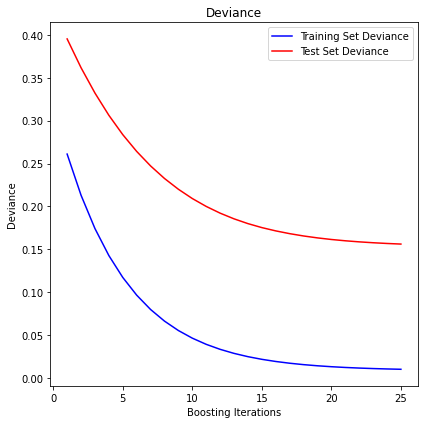

In [ ]:
params = 25

test_score = np.zeros((params,), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = sm.mean_absolute_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params) + 1,
    gbr.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

### XGB Regressor

In [ ]:
# tree_para = {'n_estimators':[25,50,75,100], 
#              'max_depth':[25,50,75,100], 
#              }

# clf_xgb = GridSearchCV(XGBRegressor(random_state = 123,
#                                 verbosity = 0), 
#                    tree_para, 
#                    cv=5)

# clf_xgb.fit(X_train, y_train)

# train_mae_xgb = sm.mean_absolute_error(y_train, 
#                                    clf_xgb.best_estimator_.predict(X_train))

# test_mae_xgb = sm.mean_absolute_error(y_test, 
#                                   clf_xgb.best_estimator_.predict(X_test))

# print(f"The optimal parameter is   : {clf_xgb.best_params_}")
# print(f"The best training MAE is : {round(train_mae_xgb,3)}")
# print(f"The best testing MAE is  : {round(test_mae_xgb,3)}")

# print(f"The training accuracy is   : {round(clf_xgb.best_estimator_.score(X_train, y_train)*100,4)}%")
# print(f"The testing accuracy is    : {round(clf_xgb.best_estimator_.score(X_test, y_test)*100,4)}%")

# The optimal parameter is   : {'max_depth': 25, 'n_estimators': 25}

In [18]:
xgb = XGBRegressor(random_state = 123,
                   verbosity = 0,
                   max_depth = 25, 
                   n_estimators=25
                   )

xgb.fit(X_train, y_train)

train_mae_xgb = sm.mean_absolute_error(y_train, 
                                   xgb.predict(X_train))

test_mae_xgb = sm.mean_absolute_error(y_test, 
                                  xgb.predict(X_test))

print(f"The best training MAE is : {round(train_mae_xgb,3)}")
print(f"The best testing MAE is  : {round(test_mae_xgb,3)}")

print(f"The training R Square is   : {round(xgb.score(X_train, y_train),4)}")
print(f"The testing R Square is    : {round(xgb.score(X_test, y_test),4)}")

The best training MAE is : 0.325
The best testing MAE is  : 0.339
The training R Square is   : 0.5578
The testing R Square is    : 0.4865


In [19]:
xgb_feature_importance = pd.DataFrame({
    'Feature Name': xgb.get_booster().feature_names,
    'Feature Importance': xgb.feature_importances_,
})


xgb_feature_importance = xgb_feature_importance.nlargest(10, 'Feature Importance')


## Results Summary

In [ ]:
pred_dt = dt.predict(X_test)
pred_dt_simp = dt_simp.predict(X_test_simplified)
pred_rf = rf.predict(X_test)
pred_gbr = dt.predict(X_test)
pred_xgb = dt.predict(X_test)

In [ ]:

pd.DataFrame(pred_dt).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Prediction_dt_test.csv',index=False)
pd.DataFrame(pred_dt_simp).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Prediction_dt_simp_test.csv',index=False)
pd.DataFrame(pred_rf).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Prediction_rf_test.csv',index=False)
pd.DataFrame(pred_gbr).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Prediction_gbr_test.csv',index=False)
pd.DataFrame(pred_xgb).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Prediction_xgb_test.csv',index=False)


In [ ]:
pred_dt = dt.predict(X_train)
pred_dt_simp = dt_simp.predict(X_train_simplified)
pred_rf = rf.predict(X_train)
pred_gbr = dt.predict(X_train)
pred_xgb = dt.predict(X_train)

In [ ]:
pd.DataFrame(pred_dt).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Prediction_dt_train.csv',index=False)
pd.DataFrame(pred_dt_simp).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Prediction_dt_simp_train.csv',index=False)
pd.DataFrame(pred_rf).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Prediction_rf_train.csv',index=False)
pd.DataFrame(pred_gbr).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Prediction_gbr_train.csv',index=False)
pd.DataFrame(pred_xgb).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Prediction_xgb_train.csv',index=False)

In [20]:
pd.DataFrame(dt_feature_importance).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Feature_Importance_dt.csv',index=False)
pd.DataFrame(dt_simp_feature_importance).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Feature_Importance_dt_simp.csv',index=False)
pd.DataFrame(rf_feature_importance).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Feature_Importance_rf.csv',index=False)
pd.DataFrame(gbr_feature_importance).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Feature_Importance_gbr.csv',index=False)
pd.DataFrame(xgb_feature_importance).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Feature_Importance_xgb.csv',index=False)